In [1]:
%load_ext autoreload
%autoreload 2

import torch
from model import PointNet
from dataset import lm2flat_index
from matplotlib import pyplot as plt

In [2]:
from typing import List, Tuple
from dataset import OctantDataset
from torch.utils.data import DataLoader
from pytorch3d.structures import Pointclouds

ds = OctantDataset("../dataset/toy")

def collate_batched_point_clouds(batch: List[Tuple[Pointclouds, torch.Tensor]]):
    coefs = torch.stack([x[1] for x in batch])
    pcs = Pointclouds(
        points=[x[0].points_packed() for x in batch],
        features=[x[0].features_packed() for x in batch],
    )
    return (pcs, coefs)


train_dataloader = DataLoader(
    ds, batch_size=2, shuffle=True, collate_fn=collate_batched_point_clouds
)



Text(0, 0.5, 'loss')

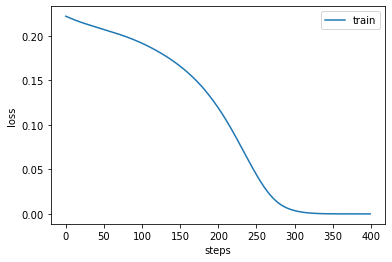

In [3]:
l = 3

model = PointNet((l + 1) ** 2).cuda()
model.train()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

mse_loss = torch.nn.MSELoss()

epochs = 400
loss_hist = []
step = 0

for epoch in range(epochs):
    for pcs, coefs in iter(train_dataloader):
        vertices = pcs.points_packed().cuda()
        color = (pcs.features_packed().float() / 255.0).cuda()[:, :3]
        batch = pcs.packed_to_cloud_idx().cuda()
        target_coefs = coefs[:, : lm2flat_index(l, -l) + 1].cuda()

        optimizer.zero_grad()

        pred_coefs = model(vertices, color, batch)
        train_loss = mse_loss(pred_coefs, target_coefs)
        train_loss.backward()
        optimizer.step()
        loss_hist.append(train_loss.item())

plt.plot(loss_hist, label="train")
plt.legend()
plt.xlabel("steps")
plt.ylabel("loss")
